# Selectivity categories for spectral results

In [1]:
import re
import h5py
import numpy as np
import pandas as pd

from scipy import stats
from mne.stats import fdr_correction
from string import ascii_letters as abc
from itertools import product
from os.path import join as pjoin

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

# list of subject names
print(sujs)

['sub-9d783b836f5e', 'sub-14c725b6b803', 'sub-28e70e7c7fbb', 'sub-83ebd5328120', 'sub-cacae171ee15', 'sub-95a634be7e05', 'sub-26176ef8a8d0', 'sub-44375d501493', 'sub-a4e7fc9daa96', 'sub-c1b7ce54ce05', 'sub-3ef8645f99c5', 'sub-fccb4adbfadc', 'sub-ebf231d97f73', 'sub-e0bb6ccef2a5', 'sub-4247d6d6cdbf', 'sub-45a6830d263e', 'sub-82e330f8aadd', 'sub-c2a96116ddc4']


In [2]:
# shortcut to joining var strings
def jn(mlist, char=None):
    """Summary

    Parameters
    ----------
    mlist : list
       List of strings to concatenate.
    join : str, optional
       Character for concatenation.

    Returns
    -------
    Concatenated string
    """
    if char is None:
        string = '_'.join(mlist)
    else:
        string = char.join(mlist)

    return string

**Fixed variables** 

In [3]:
analysis = 'spectral'
outlier = 'noout'
alpha = .01
h5_path = pjoin('/Volumes',
                'Transcend',
                'ispeech_motorspeech_transcend',
                'projects',
                'ispeech',
                'data',
                'data_h5', )

In [4]:
cat_df = {}
b_d = {}

*Lists*

In [5]:
sounds = ['speech', 'music']
hemis = ['left', 'right']

# all bands
bands = ['delta', 'theta', 'alpha', 'beta', 'lga', 'hfa']
bands_r = ((1, 4), (5, 8), (8, 12), (18, 30), (30, 50), (80, 120))

# previous bands (delta from 1, HFa envelope correlation)
p_bands = ['delta', 'hfa']

# new custom bands
c_bands = ['theta', 'alpha', 'beta', 'lga']

*Band inidices in morlet*

In [6]:
freqs = np.logspace(np.log2(1), np.log2(150), num=100, base=2)
for b, r in zip(bands, bands_r):
    idx = [(np.abs(freqs - value)).argmin() for value in r]
    idx = (idx[0], idx[1] + 1)
    b_d[b + '_morlet_i'] = idx
    print(b, r, idx, np.round(freqs, 2)[slice(idx[0], idx[1])])

delta (1, 4) (0, 28) [1.   1.05 1.11 1.16 1.22 1.29 1.35 1.43 1.5  1.58 1.66 1.74 1.84 1.93
 2.03 2.14 2.25 2.36 2.49 2.62 2.75 2.89 3.04 3.2  3.37 3.54 3.73 3.92]
theta (5, 8) (32, 42) [5.05 5.31 5.59 5.88 6.18 6.51 6.84 7.2  7.57 7.97]
alpha (8, 12) (41, 50) [ 7.97  8.38  8.81  9.27  9.75 10.26 10.79 11.35 11.94]
beta (18, 30) (57, 68) [17.9  18.83 19.81 20.84 21.92 23.06 24.25 25.51 26.84 28.23 29.7 ]
lga (30, 50) (67, 78) [29.7  31.24 32.86 34.57 36.36 38.25 40.23 42.32 44.52 46.83 49.26]
hfa (80, 120) (87, 96) [ 81.72  85.96  90.42  95.12 100.06 105.25 110.72 116.46 122.51]


*Some little functions*

In [11]:
def get_name(data, analysis=analysis, condition=None):
    if condition:
        cname = jn([analysis, condition, data, outlier, 'sign'])
    else:
        cname = jn([analysis, 'difference', data, 'sign'])
    return cname

*Plotting colors and cmaps*

In [12]:
color = {
    'speech': [  # red
        np.array((242, 152, 154)).reshape(1, -1),
        np.array((254, 75, 73)).reshape(1, -1),
        np.array((219, 129, 130)).reshape(1, -1),
    ],
    'music': [  # blue
        np.array((148, 210, 221)).reshape(1, -1),
        np.array((43, 183, 200)).reshape(1, -1),
        np.array((114, 183, 194)).reshape(1, -1),
    ],
    'shared': [  # yellow
        np.array((243, 222, 168)).reshape(1, -1),
        np.array((255, 214, 102)).reshape(1, -1),
        np.array((220, 199, 145)).reshape(1, -1),
    ],
    'neither_grey': [  # grey
        np.array((230, 229, 234)).reshape(1, -1),
        np.array((184, 183, 187)).reshape(1, -1),
        np.array((132, 131, 134)).reshape(1, -1),
    ]}

color['shared'][1] = np.array([[255, 255, 255]])

## Prepare DataFrame

### **Collect base data** from presaved DF and add data of interest

The conditions of our ethics approval do not permit public archiving of anonymised study data. Readers seeking access to the data should contact the lead author. Access will be granted to named individuals in accordance with ethical procedures governing the reuse of clinical data, including completion of a formal data sharing agreement.

In [ ]:
# collect ispeech dataframe and add other infos
path = pjoin(h5_path, 'h5_df')
with pd.HDFStore(pjoin(path, 'ispeech_base_df.h5'), mode='r') as store:
    df = store.select('df')

*Add column to be able to, in the brain plots, plot deeper channels first*

In [14]:
df['chorder'] = [min(re.findall(r'\d+', c)) for c in df.chnames]

### Add statistics

#### Add **difference effects** for all bands ***except HGA*** &rarr; ***morlet!***

In [15]:
columns = ['spectral_morlet_speech', 'spectral_morlet_music']

for band in bands:
    idx = b_d[band + '_morlet_i']

    data = np.array([x for x in df[columns[0]].values])
    c1 = np.nanmean(data[:, slice(idx[0], idx[1])], axis=1)
    data = np.array([x for x in df[columns[1]].values])
    c2 = np.nanmean(data[:, slice(idx[0], idx[1])], axis=1)
    tstat, pval = stats.ttest_ind(c1, c2, axis=1, nan_policy='omit')

    # correct for multiple comparison
    mask = np.isfinite(pval)
    _, pval[mask] = fdr_correction(pval[mask])

    # all sign indexes
    indexes = [x[0] for x in np.argwhere(pval < alpha)]
    sign_df = df.iloc[indexes]
    name = '%s_difference_%s' % (analysis, band)
    sign_df[jn([name, 'sign'])] = [x for x in tstat[indexes]]
    df = df.join(sign_df[jn([name, 'sign'])]).fillna(df)

#### Add **main effects** for all bands

##### Average morlet within bands

In [16]:
# reduce spectral columns
for column, band in product(columns, bands):
    sound = column.split('_')[-1]
    idx = b_d[band + '_morlet_i']
    data = np.array([x for x in df[column].values])
    c1 = np.nanmean(data[:, slice(idx[0], idx[1])], axis=1)
    c = jn([analysis, sound, band])
    df[c] = np.nanmean(c1, 1)

##### Get rid of outliers and determine significance threshold

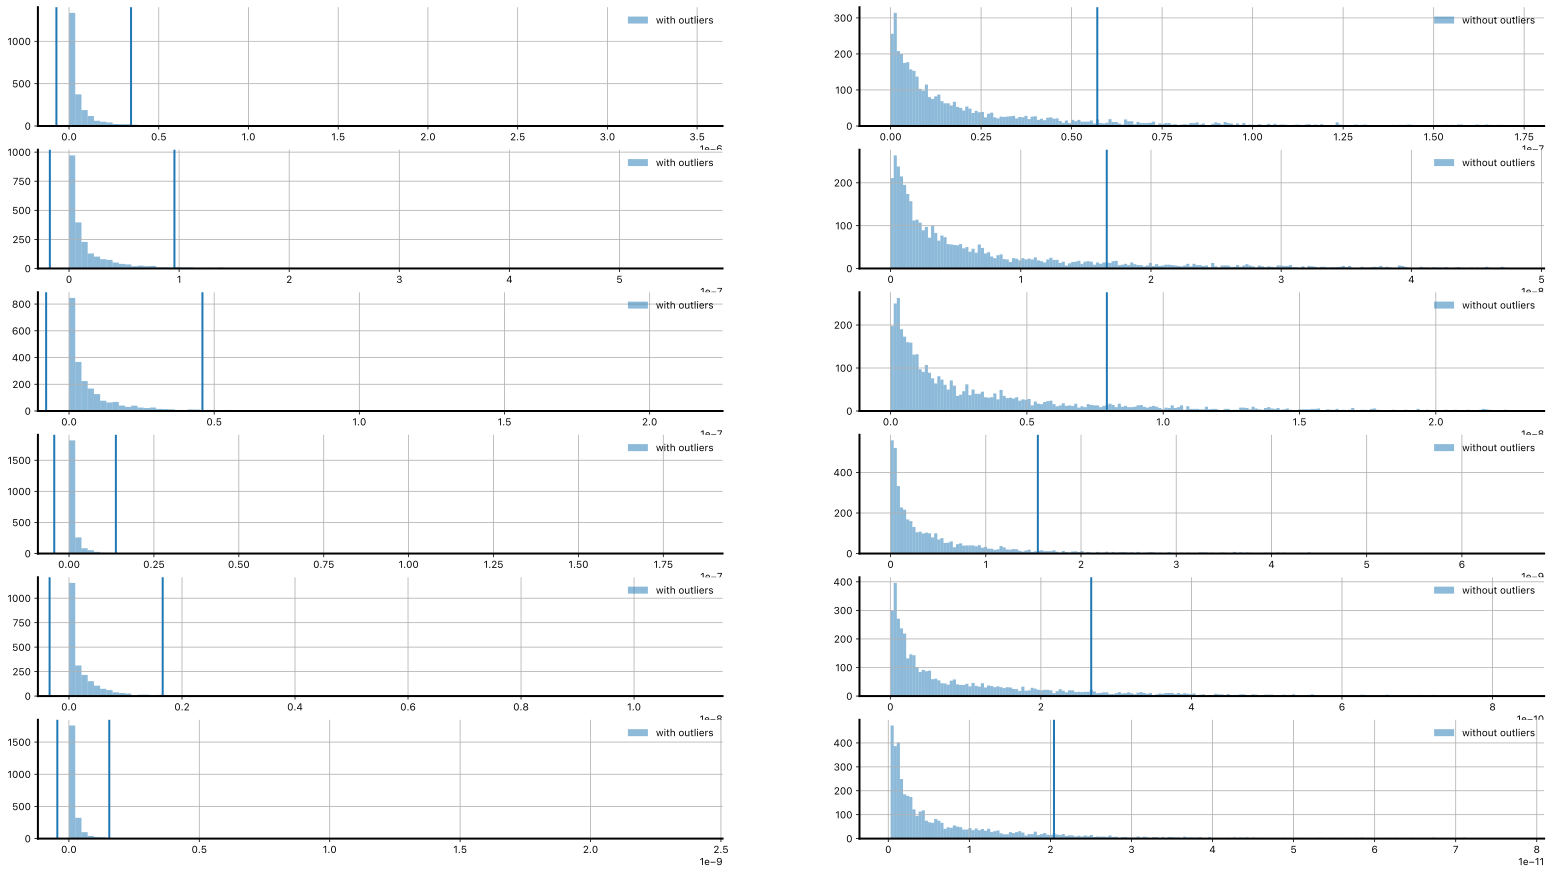

In [17]:
d = {}
l_outlier = 1
r_outlier = 2
r_sign = 1
fig, ax = plt.subplots(len(bands), 2, figsize=(27, 15))

for i, band in enumerate(bands):

    faxes = ax[i, 0]
    saxes = ax[i, 1]

    # collect data
    for sound in sounds:
        d_name = jn([analysis, sound, band])
        d[d_name] = df[d_name].values

    # average speech and music
    d[jn([band, 'data'])] = (d['spectral_speech_' + band] +
                             d['spectral_music_' + band]) / 2

    # determine thresholds
    for threshold, limit in zip(('loutlier', 'routlier', 'sign'), (l_outlier, r_outlier, r_sign)):
        if threshold == 'loutlier':
            d[jn([band, threshold])] = np.nanmean(d[jn([band, 'data'])]
                                                  ) - (limit * np.nanstd(d[jn([band, 'data'])]))
        else:
            d[jn([band, threshold])] = np.nanmean(d[jn([band, 'data'])]
                                                  ) + (limit * np.nanstd(d[jn([band, 'data'])]))

    # plot figure
    faxes.hist(d[jn([band, 'data'])], bins=100,
               label='with outliers', alpha=.5)
    faxes.axvline(x=d[jn([band, 'routlier'])])
    faxes.axvline(x=d[jn([band, 'loutlier'])])
    faxes.legend()

    # save significants without outlier removal and then remove outliers
    for sound in sounds:
        d_name = jn([analysis, sound, band])
        d[jn([d_name, 'noout'])] = [x if x < d[jn([band, 'routlier'])]
                                    and x > d[jn([band, 'loutlier'])] else np.nan for x in d[d_name]]
        df[jn([d_name, 'outlier_sign'])] = [
            x if x > d[jn([band, 'sign'])] else np.nan for x in d[d_name]]

    # average speech and music of new data
    d[jn([band, 'data_noout'])] = np.array(d['spectral_speech_' +
                                             band + '_noout'] + d['spectral_music_' + band + '_noout']) / 2

    # select significants threshold
    d[jn([band, 'sign'])] = np.nanmean(d[jn([band, 'data_noout'])]) + \
        (r_sign * np.nanstd(d[jn([band, 'data_noout'])]))
    for sound in sounds:
        d_name = jn([analysis, sound, band, 'noout'])
        df[jn([d_name, 'sign'])] = [
            x if x > d[jn([band, 'sign'])] else np.nan for x in d[d_name]]

    # plot figure
    saxes.hist(d[jn([band, 'data_noout'])], bins=200,
               label='without outliers', alpha=.5)
    saxes.axvline(x=d[jn([band, 'sign'])])
    saxes.legend()

Check counts

In [18]:
for band in bands:
    name = '%s_difference_%s_sign' % (analysis, band)
    print(band, '->',
          'total: %s;' % len(df.loc[(df[name].notnull())]),
          'speech: %s;' % len(df.loc[(df[name] > 0)]),
          'music: %s;' % len(df.loc[(df[name] < 0)]))

delta -> total: 891; speech: 301; music: 590;
theta -> total: 1149; speech: 348; music: 801;
alpha -> total: 1094; speech: 436; music: 658;
beta -> total: 902; speech: 402; music: 500;
lga -> total: 868; speech: 466; music: 402;
hfa -> total: 855; speech: 525; music: 330;


## Prepare intersections

***shared***:
- main effect for both significant and no difference effect (green) -> both_no
    
***almost shared***:
- main effect for speech but no difference effect -> sp_no
- main effect for music but no difference effect -> mu_no
    
***preferred***:
- main effect for both but difference effect for speech -> both_sp 
- main effect for both but difference effect for music -> both_mu 

***selective***:
- main effect only for speech plus difference effect (red) -> sp_sp
- main effect only for music plus difference (effect (blue) -> mu_mu
    
***impossible situation but check for it***:
- neither but difference speech -> no_sp
- neither but difference music -> no_mu
---

***shared***

In [19]:
include_almost_shared = True
for band in bands:
    temp = df
    columns = [get_name(data=band, condition=sound) for sound in sounds]

    print(band, len(temp.loc[(temp[columns].notnull().any(axis=1))]))

    # including almost shared
    if include_almost_shared:
        cat_df['shared_' + band] = temp.loc[(temp[columns].notnull().any(
            axis=1)) & ~(temp[get_name(data=band)].notnull())]

    # excluding almost shared
    else:
        cat_df['shared_' + band] = temp.loc[(temp[columns].notnull().all(
            axis=1)) & ~(temp[get_name(data=band)].notnull())]

    print(band, '-> shared %s' % len(cat_df['shared_' + band]))

delta 697
delta -> shared 363
theta 707
theta -> shared 323
alpha 729
alpha -> shared 368
beta 566
beta -> shared 338
lga 683
lga -> shared 432
hfa 626
hfa -> shared 384


***preferred***

In [20]:
for band in bands:
    temp = df
    columns = [get_name(data=band, condition=sound) for sound in sounds]
    cat_df['speech_preferred_' + band] = temp.loc[(
        temp[columns].notnull().all(axis=1)) & (temp[get_name(data=band)] > 0)]
    cat_df['music_preferred_' + band] = temp.loc[(
        temp[columns].notnull().all(axis=1)) & (temp[get_name(data=band)] < 0)]
    print(band, '->',
          'speech: %s;' % len(cat_df['speech_preferred_' + band]),
          'music: %s;' % len(cat_df['music_preferred_' + band]))

delta -> speech: 72; music: 128;
theta -> speech: 98; music: 136;
alpha -> speech: 114; music: 120;
beta -> speech: 86; music: 96;
lga -> speech: 104; music: 110;
hfa -> speech: 120; music: 103;


***selective***

In [21]:
for band in bands:
    temp = df
    cat_df['speech_selective_' + band] = temp.loc[(temp[get_name(data=band, condition='speech')] > 0) & ~(
        temp[get_name(data=band, condition='music')] > 0) & (temp[get_name(data=band)] > 0)]
    cat_df['music_selective_' + band] = temp.loc[~(temp[get_name(data=band, condition='speech')] > 0) & (
        temp[get_name(data=band, condition='music')] > 0) & (temp[get_name(data=band)] < 0)]
    print(band, '->',
          'speech: %s;' % len(cat_df['speech_selective_' + band]),
          'music: %s;' % len(cat_df['music_selective_' + band]))

delta -> speech: 31; music: 68;
theta -> speech: 27; music: 79;
alpha -> speech: 30; music: 64;
beta -> speech: 15; music: 24;
lga -> speech: 16; music: 11;
hfa -> speech: 7; music: 8;


## Grid: **Electrodes distribution** (MNI) and **overview categories** (nested pies) per band

Some **plotting prefixes**

In [22]:
# fontsizes
fticks = 27
flabels = 35
fcount = 52
lwidth = 2  # line width
size = .3  # pie sizes

# filters to loop over
visuals = ['shared', 'preferred', 'selective']
bars = ['shared', 'speech_preferred', 'music_preferred',
        'speech_selective', 'music_selective']

emdash = u'\u2014'
hatchp = 'x'

outer_colors = [np.array((255, 255, 255)).reshape(1, -1) / 255,
                np.array((52, 52, 53)).reshape(1, -1) / 255,
                color['neither_grey'][2] / 255]
inner_colors = [color['shared'][1] / 255] + [color[sound]
                                             [1] / 255 for i, sound in product(range(2)[::-1], sounds)]

matplotlib.rcParams['hatch.linewidth'] = 2.0

In [21]:
fig3 = plt.figure(figsize=(27, 37), constrained_layout=False)

# collect stored mayavi brain images
path = pjoin(h5_path, 'h5_electrodes')

for z, band in enumerate(bands):
    gs = fig3.add_gridspec(2, 2,
                           wspace=.1,
                           hspace=-.3,
                           left=0 if z < 3 else .55,
                           right=.45 if z < 3 else 1,
                           bottom=(3 - z % 3) * .3,
                           top=((3 - z % 3) + 1) * .3)

    band_name = 'HFa' if band == 'hga' else 'low gamma' if band == 'lga' else band

    # Brain figure
    ##############################################################################
    for o, orientation in enumerate(hemis):

        # which axes
        con_orientation = fig3.add_subplot(gs[1, o])
        axes = con_orientation

        # collect stored mayavi brain images
        with h5py.File(pjoin(path, 'mayavi_electrodes.hdf5'), 'r') as hf:
            im = hf[orientation]['imp'][...]
        axes.imshow(im)

        for j in range(20):

            for v, viz in enumerate(visuals):
                if viz == 'preferred':
                    continue
                for sound in sounds[::-1]:
                    if viz != 'shared':
                        label = jn([sound, viz, band])
                    else:
                        if sound == 'music':
                            continue
                        label = jn([viz, band])

                    # filter dataframe and move on if nothing matches
                    temp_df = cat_df[label]
                    temp_df = temp_df.loc[(temp_df['chorder'] == str(j))]
                    if len(temp_df) == 0:
                        continue

                    # collect coordinates
                    df_x = temp_df[jn([orientation, 'x'])].values
                    df_y = temp_df[jn([orientation, 'y'])].values
                    left_i, right_i = [], []
                    for i, ch in enumerate(temp_df['chnames'].values):
                        if "'" in ch:
                            left_i.append(i)
                        else:
                            right_i.append(i)
                    if orientation in hemis:
                        x_h = df_x[left_i] if orientation == 'left' else df_x[right_i]
                        y_h = df_y[left_i] if orientation == 'left' else df_y[right_i]
                    else:
                        x_h = df_x
                        y_h = df_y

                    # plot elecs scatterplot
                    axes.scatter(x_h,
                                 y_h,
                                 edgecolors='k',
                                 color=outer_colors[v] if 'selective' not in viz else color[label.split('_')[
                                     0]][1] / 255,
                                 label='%s %s' % (len(x_h), label),
                                 s=120 * np.ones(len(x_h)),
                                 marker="o",
                                 linewidth=lwidth)

                    # clean up subplot
                    axes.set_axis_off()

    # Band title figure
    ##############################################################################
    band_title = fig3.add_subplot(gs[0, 0])
    axes = band_title
    axes.set_title(abc[z].upper(), fontsize=fcount, loc='left', y=0.7)
    axes.text(.5,
              .5,
              '%s band\n(%s %s %s Hz)' % (
                  band_name,
                  bands_r[z][0],
                  emdash,
                  bands_r[z][1]),
              fontsize=fcount-10,
              ha='center', va='center')
    # clean up subplot
    axes.set_axis_off()

    # Nested pie figure
    ##############################################################################
    nested_pie = fig3.add_subplot(gs[0, 1])
    axes = nested_pie

    # prepare counts per category for the rings
    inner_len = [len(cat_df[jn([bar, band])]) for bar in bars]
    outer_len = [len(cat_df[jn(['shared', band])])] + [len(cat_df[jn(['speech', viz, band])]
                                                           ) + len(cat_df[jn(['music', viz, band])]) for viz in visuals[1:]]

    # sum of significant electrodes
    all_sum = np.array([len(cat_df[jn([bar, band])]) for bar in bars]).sum()

    # percentage significant electrodes over whole brain
    # in total and per category
    p_overbrain = np.round((all_sum / len(df)) * 100, 1)
    percentages = ['%s%%' % np.round((j / all_sum) * 100, 1)
                   for j in outer_len]

    # plot outer pie
    axes.pie(outer_len,
             radius=1,
             colors=outer_colors,
             labels=percentages,
             wedgeprops=dict(width=size, edgecolor='k', linewidth=lwidth))

    # inner pie
    inner = axes.pie(inner_len,
                     radius=1 - size,
                     colors=inner_colors,
                     wedgeprops=dict(width=size, edgecolor='k', linewidth=lwidth))

    # add hatch pattern to preferred
    for h in range(2):
        inner[0][h+1].set_hatch(hatchp)
        inner[0][h+1].set_edgecolor(np.array((52, 52, 53)
                                             ).reshape(1, -1) / 255)

    axes.text(0., 0.,
              '%s%%' % (p_overbrain),
              fontsize=flabels,
              ha='center',
              va='center')


# prepare legend
###########################################################################################
gs = fig3.add_gridspec(1, 2, top=1.25)
legend_s = fig3.add_subplot(gs[0, :])
axes = legend_s

# legend patches
sounds_l = [mpatches.Patch(facecolor=color[sound][1] /
                           255, label=sound, edgecolor='k', linewidth=lwidth) for sound in sounds]
category_l = [mpatches.Patch(facecolor=outer_colors[i], edgecolor='k', label=cat)
              for i, cat in enumerate(visuals)]
axes.legend(handles=sounds_l + category_l,
            ncol=6,
            loc='upper right',
            labelspacing=.7,
            frameon=False)
axes.set_axis_off()